# ***Importing Libraries***

In [1]:
pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.0 MB/s eta 0:00:00


In [2]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , roc_auc_score
from xgboost import XGBClassifier
import statsmodels.api as sm


from transformers import BertTokenizer, BertModel
import torch
from transformers import DistilBertTokenizer, DistilBertModel

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from textblob import TextBlob
import spacy , contractions
import nltk , re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from datetime import datetime
from nltk.tokenize import word_tokenize, sent_tokenize
import joblib

from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization , LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# ***Loading Prediction Data Set***

In [3]:
df = pd.read_excel('/content/PredictionData.xlsx')

In [4]:
df.drop(columns = ['Unnamed: 0.1' , 'Unnamed: 0' , 'num_words_in_transcript'] , inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   100 non-null    object
 1   Name                 100 non-null    object
 2   Role                 100 non-null    object
 3   Transcript           100 non-null    object
 4   Resume               100 non-null    object
 5   Reason for decision  100 non-null    object
 6   Job Description      100 non-null    object
dtypes: object(7)
memory usage: 5.6+ KB


# ***Pre processing Data***

In [6]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
class Preprocessing:

  def __init__(self , data):
    self.data = data
    print('Initiating the Pre processing \n')
    self.textProcessing()

  def textProcessing(self):

    print('Step 1/8 ==> Started ............')

    nlp = spacy.load("en_core_web_sm")
    stopword_s = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()

    def pre_process(text):
      text = contractions.fix(text) # expanding the contractions like , I'm with I am and it's with It is and so on...
      text = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@\[\]^_`{|}~]', '', text)  # Removing all these characters from the text
      sentences = re.split(r'(?<=[.!?])\s+', text)   # Splitting the text as sentences using the regular expressions
      for idx, sent in enumerate(sentences):
          words = nlp(sent)  # converting the sentence into words
          words = [word.text for word in words if word.text.lower() not in stopword_s] # Removing the stopwords from the text
          words = [lemmatizer.lemmatize(word) for word in words]  # Using the Lemmatization techniques
          sentences[idx] = ' '.join(words)  # Replacing the original sentence with the new sentence
      return ' '.join(sentences)  # Join the sentences back together

    self.data['Resume_processed'] = self.data['Resume'].apply(pre_process)
    self.data['Job_Description_processed'] = self.data['Job Description'].apply(pre_process)
    self.data['Transcript_processed'] = self.data['Transcript'].apply(pre_process)

    print('Step 1/8 ==> Pre processing of texts in the dataset executed Successfully \n')

    self.analyze_sentiment()

  def analyze_sentiment(self):

    print('Step 2/8 ==> Started ............')

    def sentiment(text):
      # Create a TextBlob object
      blob = TextBlob(text)

      # Get the sentiment polarity
      polarity = blob.sentiment.polarity

      return polarity

    self.data['Transcript_sentiment'] = self.data['Transcript_processed'].apply(sentiment)
    self.data['Resume_sentiment'] = self.data['Resume_processed'].apply(sentiment)
    self.data['JobDescription_sentiment'] = self.data['Job_Description_processed'].apply(sentiment)

    print('Step 2/8 ==> Sentiment Calculation of Each colum Excuted Succesfully \n')

    self.word_counts()

  def word_counts(self):

    print('Step 3/8 ==> Started ............')

    def counts(text):
      return len(text.split())

    self.data['Transcript_words'] = self.data['Transcript_processed'].apply(counts)
    self.data['Resume_words'] = self.data['Resume_processed'].apply(counts)

    print('Step 3/8 ==> Extracting Word Counts Excuted Succesfully \n')

    self.extract_years_of_experience()

  def extract_years_of_experience(self):

      print('Step 4/8 ==> Started ............')

      def years_of_experience(text):
          # Regular expression to extract years and date ranges
          date_ranges = re.findall(r"(\d{4})-(present|\d{4})", text.lower())

          total_years = 0
          current_year = datetime.now().year

          for start, end in date_ranges:
              start_year = int(start)
              end_year = current_year if end == "present" else int(end)

              total_years += (end_year - start_year)

          return total_years
      self.data['Years_Experience']=self.data['Resume'].apply(years_of_experience)

      print('Step 4/8 ==> Extracting Years of Experience Excuted Succesfully \n')
      self.process_dataset()


  def extract_resume_features(self,resume_text, jd_text):
    features = {}

    # Length-based features
    features['resume_sentence_count'] = len(sent_tokenize(resume_text))
    features['resume_avg_word_length'] = sum(len(word) for word in word_tokenize(resume_text)) / len(word_tokenize(resume_text))

    # Skill match features
    jd_skills = set(re.findall(r'\b[A-Za-z]+\b', jd_text.lower()))
    resume_skills = set(re.findall(r'\b[A-Za-z]+\b', resume_text.lower()))
    features['skill_match_count'] = len(jd_skills & resume_skills)

    # Education features
    degrees = ['b.tech', 'm.tech', 'mba', 'phd', 'bachelor', 'master']
    features['university_education_count'] = sum(1 for degree in degrees if degree in resume_text.lower())

    return features

  def process_dataset(self):

    print('Step 5/8 ==> Started ............')

    def process_dataset_resume_features(data, resume_col, jd_col):
        """
        Process a dataset to extract features for each resume-JD pair.

        Parameters:
        - data (pd.DataFrame): Dataset containing resumes and job descriptions.
        - resume_col (str): Column name for resumes.
        - jd_col (str): Column name for job descriptions.

        Returns:
        - pd.DataFrame: Original dataset with extracted features appended.
        """
        extracted_features = []

        for _, row in data.iterrows():
            resume_text = row[resume_col]
            jd_text = row[jd_col]
            features = self.extract_resume_features(resume_text, jd_text)
            extracted_features.append(features)

        # Combine features into a DataFrame
        features_df = pd.DataFrame(extracted_features)
        return pd.concat([data, features_df], axis=1)

    # Process the dataset
    self.processed_data = process_dataset_resume_features(self.data, "Resume_processed", "Job_Description_processed")

    print('Step 5/8 ==> Extracting Resume Features Excuted Succesfully \n')

    self.process_transcript()

  def extract_transcript_features(self,transcript_text):

    features = {}
    # Language features
    features['transcript_vocab_diversity'] = len(set(word_tokenize(transcript_text))) / len(word_tokenize(transcript_text))
    features['transcript_avg_sentence_length'] = sum(len(sent.split()) for sent in sent_tokenize(transcript_text)) / len(sent_tokenize(transcript_text))
    return features

  def process_transcript(self):

    print('Step 6/8 ==> Started ............')
    def process_transcript(data, transcript_col = 'Transcript_processed'):
      extracted_features = []

      for _, row in data.iterrows():
          transcript_text = row[transcript_col]
          features = self.extract_transcript_features(transcript_text)
          extracted_features.append(features)

      # Combine features into a DataFrame
      features_df = pd.DataFrame(extracted_features)
      return pd.concat([data, features_df], axis=1)

     # Process the dataset
    self.processed_data = process_transcript(self.processed_data)

    print('Step 6/8 ==> Extracting Transcript Features Excuted Succesfully \n')

    self.tfidfSimilarityCalculator()

  def tfidfSimilarityCalculator(self):

    print('Step 7/8 ==> Started ............')

    # Loading the fitted Tf-Idf-Vectorizer Models

    resume_Jd_filename = "/content/sim_of_Resume_processed_and_Job_Description_processed.joblib"
    resume_Transcript_filename = "/content/sim_of_Resume_processed_and_Transcript_processed.joblib"
    Transcript_JD_filename = "/content/sim_of_Transcript_processed_and_Job_Description_processed.joblib"

    resume_Jd_vectorizer = joblib.load(resume_Jd_filename)
    resume_Transcript_vectorizer = joblib.load(resume_Transcript_filename)
    Transcript_JD_vectorizer = joblib.load(Transcript_JD_filename)

    #  Transform new text data
    def similarity_calculator(vectorizer , col1 , col2):

      col1_vector = resume_Jd_vectorizer.transform(self.data[col1]).toarray()
      col2_vector = resume_Jd_vectorizer.transform(self.data[col2]).toarray()

      similarities = [
          cosine_similarity(col1_vector[i].reshape(1, -1), col2_vector[i].reshape(1, -1))[0][0]
          for i in range(len(col1_vector))]
      return similarities

    # Compute cosine similarity
    self.processed_data['Resume_Jd_similarity'] = similarity_calculator(resume_Jd_vectorizer , 'Resume_processed' , 'Job_Description_processed')
    self.processed_data['Resume_Transcript_similarity'] = similarity_calculator(resume_Transcript_vectorizer , 'Resume_processed' , 'Transcript_processed')
    self.processed_data['Transcript_Jd_similarity'] = similarity_calculator(Transcript_JD_vectorizer , 'Transcript_processed' , 'Job_Description_processed')

    print('Step 7/8 ==> Similarity Calculation Excuted Succesfully \n')

    self.bertEmbeddings()


  def bertEmbeddings(self):

    print('Step 8/8 ==> Started ............')

    transcripts = self.processed_data['Transcript'].tolist()
    resumes = self.processed_data['Resume'].tolist()
    job_desc = self.processed_data['Job Description'].tolist()

    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    model = DistilBertModel.from_pretrained("distilbert-base-uncased")

    def get_bert_embeddings_batch(texts, tokenizer, model, batch_size=32):
      embeddings = []
      total_batches = (len(texts) + batch_size - 1) // batch_size  # Total number of batches
      for i in range(total_batches):
          # Get the current batch\n",
          batch = texts[i * batch_size:(i + 1) * batch_size]
          inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=512)
          with torch.no_grad():
              outputs = model(**inputs)
          # Use the [CLS] token representation for each text in the batch\n",
          batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy(),
          embeddings.extend(batch_embeddings)
      return embeddings

    tra_emb = get_bert_embeddings_batch(transcripts, tokenizer, model, batch_size=32)
    flat_embeddings_tra = [embedding for batch in tra_emb for embedding in batch]
    self.processed_data['Transcript_bert'] = flat_embeddings_tra

    res_emb = get_bert_embeddings_batch(resumes, tokenizer, model, batch_size=32)
    flat_embeddings_res = [embedding for batch in res_emb for embedding in batch]
    self.processed_data['Resume_bert'] = flat_embeddings_res

    jd_emb = get_bert_embeddings_batch(job_desc, tokenizer, model, batch_size=32)
    flat_embeddings_jd = [embedding for batch in jd_emb for embedding in batch]
    self.processed_data['Jd_bert'] = flat_embeddings_jd

    trans_expanded = pd.DataFrame(self.processed_data['Transcript_bert'].tolist(), index=self.processed_data.index)
    trans_expanded.columns = [f'trans_emb_{i}' for i in range(trans_expanded.shape[1])]

    res_expanded = pd.DataFrame(self.processed_data['Resume_bert'].tolist(), index=self.processed_data.index)
    res_expanded.columns = [f'resume_emb_{i}' for i in range(res_expanded.shape[1])]

    jd_expanded = pd.DataFrame(self.processed_data['Jd_bert'].tolist(), index=self.processed_data.index)
    jd_expanded.columns = [f'jd_emb_{i}' for i in range(jd_expanded.shape[1])]

    self.processed_data = pd.concat([self.processed_data, trans_expanded, res_expanded , jd_expanded], axis=1)

    simi_res_tra = []
    simi_res_jd = []
    simi_tra_jd = []

    for tra , res in zip(flat_embeddings_tra , flat_embeddings_res):
      simi_res_tra.append(cosine_similarity([tra],[res])[0][0])

    for jd , res in zip(flat_embeddings_jd , flat_embeddings_res):
      simi_res_jd.append(cosine_similarity([jd],[res])[0][0])

    for tra , jd in zip(flat_embeddings_tra , flat_embeddings_jd):
      simi_tra_jd.append(cosine_similarity([tra],[jd])[0][0])

    self.processed_data['Bert_TransRes_Similarity']     = simi_res_tra
    self.processed_data['Bert_ResJobDesc_Similarity']   = simi_res_jd
    self.processed_data['Bert_TransJobDesc_Similarity'] = simi_tra_jd

    self.processed_data.drop(columns=['Transcript_bert', 'Resume_bert','Jd_bert'], inplace = True)

    print('Step 8/8 ==> BERT Embeddings Excuted Succesfully \n')





In [9]:
df_copy = df.copy()
pre_processing = Preprocessing(df_copy)

Initiating the Pre processing 

Step 1/8 ==> Started ............
Step 1/8 ==> Pre processing of texts in the dataset executed Successfully 

Step 2/8 ==> Started ............
Step 2/8 ==> Sentiment Calculation of Each colum Excuted Succesfully 

Step 3/8 ==> Started ............
Step 3/8 ==> Extracting Word Counts Excuted Succesfully 

Step 4/8 ==> Started ............
Step 4/8 ==> Extracting Years of Experience Excuted Succesfully 

Step 5/8 ==> Started ............
Step 5/8 ==> Extracting Resume Features Excuted Succesfully 

Step 6/8 ==> Started ............
Step 6/8 ==> Extracting Transcript Features Excuted Succesfully 

Step 7/8 ==> Started ............
Step 7/8 ==> Similarity Calculation Excuted Succesfully 

Step 8/8 ==> Started ............


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Step 8/8 ==> BERT Embeddings Excuted Succesfully 



In [10]:
pre_processed_data = pre_processing.processed_data

In [11]:
xgb_file = '/content/xgb_bert.joblib'
nn_file = '/content/ann_model.h5'

xgb_model = joblib.load(xgb_file)

In [12]:
# Load the saved model
ann_model = load_model(nn_file)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# ***Predictions***

Best performining model is the ensemble model of average probability of XGBoost and NeuralNetwork

In [13]:
def xgb_preds(model , data):
  preds = model.predict_proba(data)[:, 1]
  return preds

In [14]:
def ann_preds(model , data):
  preds = model.predict(data)
  preds = [i[0] for i in preds]
  return preds

Columns that are used in the XGB model and ANN model

In [15]:
derived_features = pre_processed_data[['Transcript_sentiment','Resume_sentiment', 'JobDescription_sentiment', 'Transcript_words',
       'Resume_words', 'Years_Experience', 'resume_avg_word_length', 'skill_match_count','university_education_count', 'transcript_vocab_diversity',
       'transcript_avg_sentence_length' , 'Bert_TransRes_Similarity', 'Bert_TransJobDesc_Similarity' , 'Bert_ResJobDesc_Similarity']]

In [16]:
embedding_columns = [col for col in pre_processed_data.columns if col.startswith('trans_emb_') or col.startswith('resume_emb_') or col.startswith('jd_emb_')]
X = pre_processed_data[embedding_columns]

In [17]:
new_data = pd.concat([X,derived_features],axis=1)

In [18]:
pred_xgb = xgb_preds(xgb_model,new_data)

In [19]:
ann_pred = ann_preds(ann_model,new_data)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


In [ ]:
# Ensemble Predictions

In [20]:
test_df = pd.DataFrame()
test_df['XGB_Pred'] = pred_xgb
test_df['ANN_Pred'] = ann_pred

In [21]:
test_df['Ensemble_prob'] = (test_df['XGB_Pred'] + test_df['ANN_Pred'])/2

In [22]:
test_df['Ensemble_Pred'] = test_df['Ensemble_prob'].round()

# ***Decoding the prediction and mapping to either Select or Reject***

In [23]:
le = joblib.load('/content/label_encoder.joblib')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.3.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [24]:
test_df['Decision'] = le.inverse_transform(test_df['Ensemble_Pred'].astype(int))

In [25]:
test_df['Decision'].value_counts()

,count
Decision,
reject,51
select,49


In [26]:
df['Decision'] = test_df['Decision']

In [27]:
df.head() ## For prediction Data added Decision column

,ID,Name,Role,Transcript,Resume,Reason for decision,Job Description,Decision
0,rivash0038,lahar singh,software engineer,**lahar singh: software engineer candidate int...,**lahar singh**\n**software engineer candidate...,"expected_experience : 9+ years, domains: e-com...","communicated ideas clearly and effectively., h...",select
1,benjry660,benjamin ryan,data engineer,interview transcript: data engineer position\n...,here's a sample resume for benjamin ryan apply...,cultural fit,we are looking for a skilled data engineer wit...,reject
2,rivash0968,amisha bedi,data scientist,"**interview transcript: amisha bedi, data scie...",**candidate profile: amisha bedi**\n\n**role:*...,"expected_experience : 6-8 years, domains: heal...","lacked key technical skills for the role., nee...",reject
3,rivash0623,kairav mishra,product manager,**interview transcript: product manager positi...,**kairav mishra: product manager**\n\nas a sea...,"expected_experience : 6-8 years, domains: tech...","had impressive experience and qualifications.,...",select
4,bradgr792,bradley gross,product manager,product manager interview transcript\n\ninterv...,here's a sample resume for bradley gross apply...,cultural fit,we are looking for a skilled product manager w...,select


## Email Automation

In [29]:
df[['ID','Name','Role','Decision']].to_excel("Interview_Result.xlsx")
df[['ID','Name','Role','Decision']].to_csv("Interview_Result.csv")

In [33]:
# Python code to illustrate Sending mail with attachments
# from your Gmail account

# libraries to be imported
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders

fromaddr = "pavankasa86@gmail.com"
toaddr = "pavankasa86@gmail.com"

# instance of MIMEMultipart
msg = MIMEMultipart()

# storing the senders email address
msg['From'] = fromaddr

# storing the receivers email address
msg['To'] = toaddr

# storing the subject
msg['Subject'] = "Attachment: Candidate Selection Status"

# string to store the body of the mail
body = "Here is the list of candidates with their respective roles and selection status after the interview process."

# attach the body with the msg instance
msg.attach(MIMEText(body, 'plain'))

# open the file to be sent
filename = "InterviewResults.csv"
attachment = open("/content/Interview_Result.csv", "rb")

# instance of MIMEBase and named as p
p = MIMEBase('application', 'octet-stream')

# To change the payload into encoded form
p.set_payload((attachment).read())

# encode into base64
encoders.encode_base64(p)

p.add_header('Content-Disposition', "attachment; filename= %s" % filename)

# attach the instance 'p' to instance 'msg'
msg.attach(p)

# creates SMTP session
s = smtplib.SMTP('smtp.gmail.com', 587)

# start TLS for security
s.starttls()

# Authentication
s.login(fromaddr, "ybao wfiz osyi vzne")

# Converts the Multipart msg into a string
text = msg.as_string()

# sending the mail
s.sendmail(fromaddr, toaddr, text)

# terminating the session
s.quit()
print("Email Sent Succesfully")

Email Sent Succesfully


# ***Result Images after Email Automation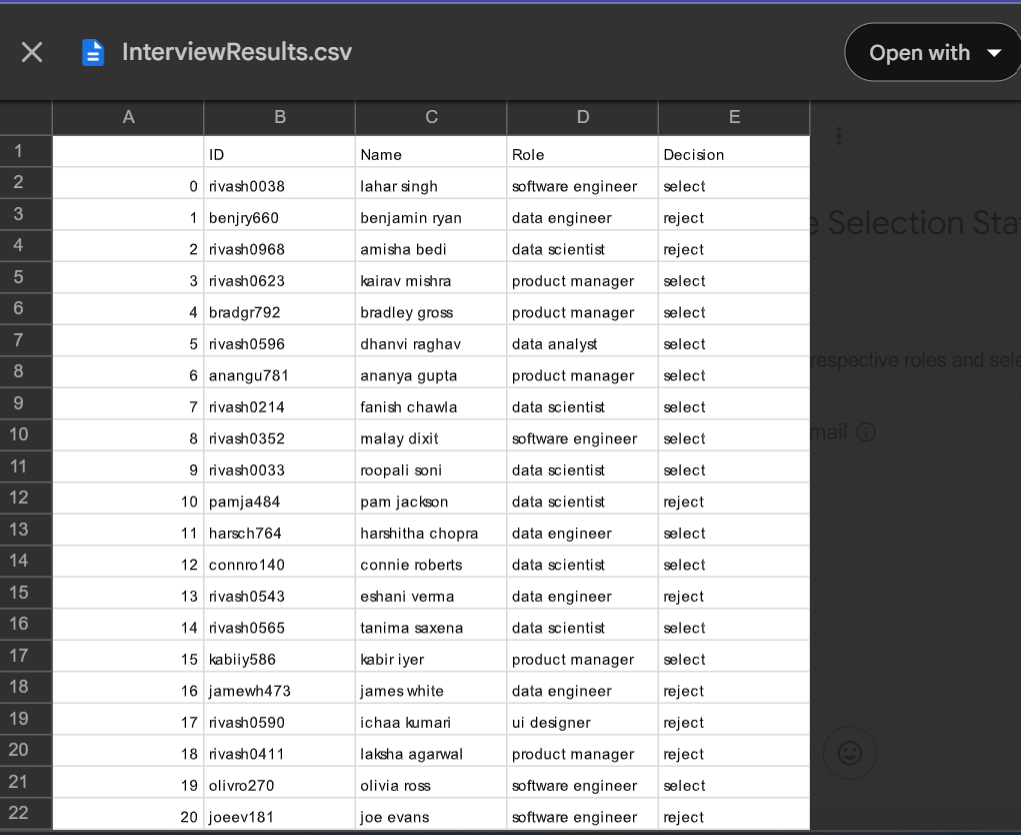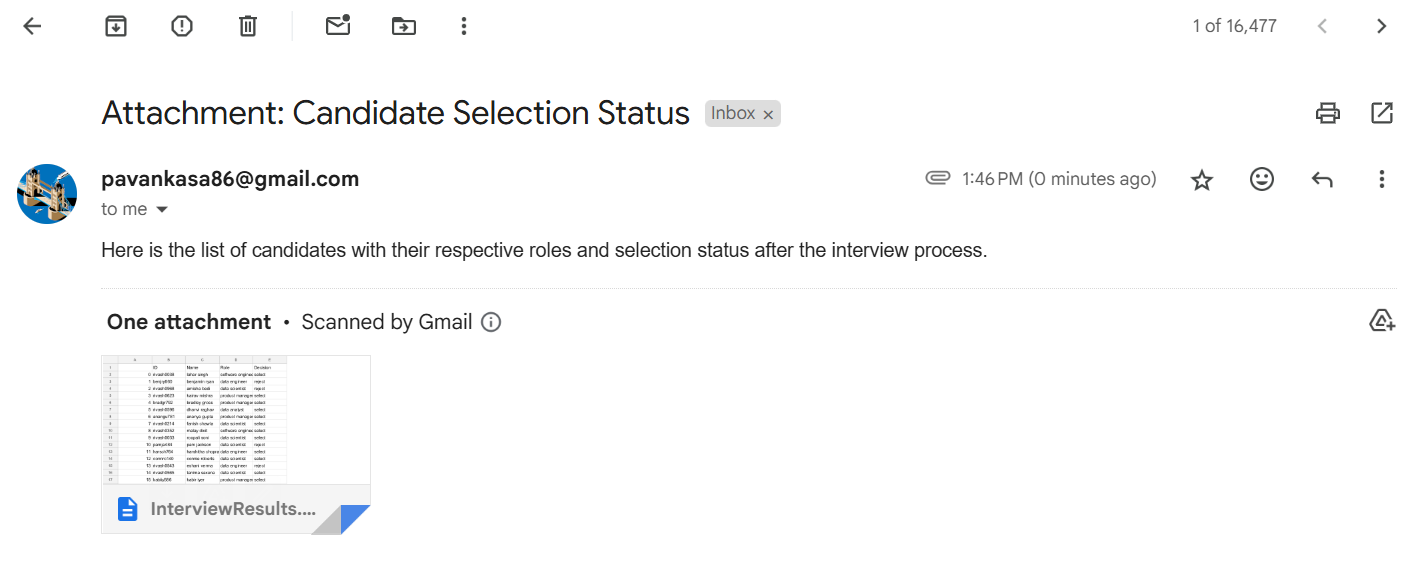***